# Packages

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import json
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from prince import FAMD, PCA
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from evolutionary_search import GeneticSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

# Load data and data preprocessing

In [2]:
# Load the raw df and we can see that the raw data is kinda messy, so we firstly need to clean and organize the data for futher task.
with open('./data/01. restaurant.csv', 'r', encoding='utf-8') as f:
    raw_data = f.readlines()
raw_data[:5]

['id;premise_name;premise_address1;premise_address2;premise_city;premise_state;premise_zip;premise_phone;hours_of_operation;opening_date;closing_date;seats;water;sewage;insp_freq;est_group_desc;risk;smoking_allowed;type_description;rpt_area_desc;status;transitional_type_desc;geolocation\n',
 '56060;WEST 94TH ST PUB;4711 HOPE VALLEY RD;SUITE 6C;DURHAM;NC;27707;(919) 403-0025;;1994-09-01;;60;5 - Municipal/Community;3 - Municipal/Community;4;Full-Service Restaurant;4;NO;1 - Restaurant;Food Service;ACTIVE;FOOD;"35.9207272; -78.9573299"\n',
 '58123;BROOKDALE DURHAM IFS;4434 BEN FRANKLIN BLVD;;DURHAM;NC;27704;(919) 479-9966;;2003-10-15;;350;5 - Municipal/Community;3 - Municipal/Community;4;Nursing Home;4;NO;16 - Institutional Food Service;Food Service;ACTIVE;FOOD;"36.0467802; -78.8895483"\n',
 '70266;SMOOTHIE KING;1125 W. NC HWY 54 SUITE 806;;DURHAM;NC;27707;(919) 489-7300;;2009-07-09;;7;5 - Municipal/Community;3 - Municipal/Community;2;Fast Food Restaurant;2;NO;1 - Restaurant;Food Service;A

In [3]:
# Get header for dataframe columes.
header = raw_data[0].split(';')
header = [i.replace('\n', '') for i in header] # eliminate the "\n"
# As our target is to build a geolocation recommandation system for restaurant business, we need first divide the geolocation column to 'latitude' & 'longitude'.
header.pop(-1)
header += ['latitude', 'longitude']
# Build the dataframe with header.
df = pd.DataFrame(columns=header)
# Load the values in row by row
# with this method, we can filter out the row that fits the desired format.
print(f'Total rows before processing: {len(raw_data[1:])}')

def str_to_float_list(s):
    """Helper for transform geolocation to float"""
    return list(map(float, re.findall(r'[-]?\d+\.\d+', s)))

count = 0
for i, v in enumerate(raw_data[1:]):
    splited_v = v.split(';')
    if len(splited_v) == len(df.columns):
        df.loc[count, :] = splited_v
        df.iloc[count, -2:] = str_to_float_list(str(df.iloc[count, -2:]))
        count += 1

print(f'Total rows after processing: {len(df)}')
df.set_index('id', inplace=True) # set id as index
df.replace('', np.NaN, inplace=True) # replace empty str to NaN
df.head()

Total rows before processing: 2472
Total rows after processing: 2432


premise_name             premise_address1   
id                                                                     
56060                  WEST 94TH ST PUB          4711 HOPE VALLEY RD  \
58123              BROOKDALE DURHAM IFS       4434 BEN FRANKLIN BLVD   
70266                     SMOOTHIE KING  1125 W. NC HWY 54 SUITE 806   
97837              HAMPTON INN & SUITES            1542 N GREGSON ST   
60690  BETTER LIVING CONCEPTS OF DURHAM                909 GARCIA ST   

      premise_address2 premise_city premise_state premise_zip   premise_phone   
id                                                                              
56060         SUITE 6C       DURHAM            NC       27707  (919) 403-0025  \
58123              NaN       DURHAM            NC       27704  (919) 479-9966   
70266              NaN       DURHAM            NC       27707  (919) 489-7300   
97837              NaN       DURHAM            NC       27701  (919) 688-8880   
60690              NaN       DURHAM            NC       27704  (919) 477-5825   

      hours_of_operation opening_date closing_date  ... insp_freq   
id                                                  ...             
56060                NaN   1994-09-01          NaN  ...         4  \
58123                NaN   2003-10-15          NaN  ...         4   
70266                NaN   2009-07-09          NaN  ...         2   
97837                NaN   2012-01-09          NaN  ...         2   
60690                NaN   2008-06-02          NaN  ...         1   

                est_group_desc risk smoking_allowed   
id                                                    
56060  Full-Service Restaurant    4              NO  \
58123             Nursing Home    4              NO   
70266     Fast Food Restaurant    2              NO   
97837  Full-Service Restaurant    2              NO   
60690                      NaN    0             N/A   

                      type_description     rpt_area_desc  status   
id                                                                 
56060                   1 - Restaurant      Food Service  ACTIVE  \
58123  16 - Institutional Food Service      Food Service  ACTIVE   
70266                   1 - Restaurant      Food Service  ACTIVE   
97837                   1 - Restaurant      Food Service  ACTIVE   
60690            43 - Residential Care  Residential Care  ACTIVE   

      transitional_type_desc   latitude  longitude  
id                                                  
56060                   FOOD  35.920727  -78.95733  
58123                   FOOD   36.04678 -78.889548  
70266                   FOOD  35.918265 -78.959326  
97837                   FOOD  36.018338 -78.906031  
60690                    N/A  36.055635 -78.913517  

[5 rows x 23 columns]

In [4]:
# As above shown, we have some cols having value as 'N/A'. Let's transform all that into np.NaN for following work.
for col in df.select_dtypes(include='object'):
    df[col].replace('N/A', np.NaN, inplace=True)

In [5]:
# As the data is formatted, we can start to do further analysis and preprocessing.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2432 entries, 56060 to 59106
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   premise_name            2432 non-null   object
 1   premise_address1        2432 non-null   object
 2   premise_address2        89 non-null     object
 3   premise_city            2432 non-null   object
 4   premise_state           2432 non-null   object
 5   premise_zip             2432 non-null   object
 6   premise_phone           1867 non-null   object
 7   hours_of_operation      138 non-null    object
 8   opening_date            2432 non-null   object
 9   closing_date            2 non-null      object
 10  seats                   1758 non-null   object
 11  water                   2432 non-null   object
 12  sewage                  2432 non-null   object
 13  insp_freq               2432 non-null   object
 14  est_group_desc          1008 non-null   object
 15  risk

In [6]:
# From this part, we can see there's a lot of missing values in this dataset
df.isna().sum()

premise_name                 0
premise_address1             0
premise_address2          2343
premise_city                 0
premise_state                0
premise_zip                  0
premise_phone              565
hours_of_operation        2294
opening_date                 0
closing_date              2430
seats                      674
water                        0
sewage                       0
insp_freq                    0
est_group_desc            1424
risk                         0
smoking_allowed           1775
type_description             0
rpt_area_desc                0
status                       0
transitional_type_desc    1136
latitude                     0
longitude                    0
dtype: int64

In [7]:
df.describe(include='object')

premise_name       premise_address1 premise_address2 premise_city   
count          2432                   2432               89         2432  \
unique         2247                   1928               67           11   
top          SUBWAY  1101 W CHAPEL HILL ST     PO BOX 90898       DURHAM   
freq             14                     39               10         2328   

       premise_state premise_zip   premise_phone   
count           2432        2432            1867  \
unique             1          28            1511   
top               NC       27707  (919) 660-3900   
freq            2432         448              14   

                         hours_of_operation opening_date closing_date  ...   
count                                   138         2432            2  ...  \
unique                                  122         1151            2  ...   
top     08:00 am-09:00 am 12:00 pm-01:00 pm   1990-07-01  21-AUG-2010  ...   
freq                                      6           60            1  ...   

       insp_freq        est_group_desc  risk smoking_allowed type_description   
count       2432                  1008  2432             657             2432  \
unique         4                     9     5               1               32   
top            2  Fast Food Restaurant     0              NO   1 - Restaurant   
freq         933                   483  1208             657              685   

       rpt_area_desc  status transitional_type_desc     latitude    longitude  
count           2432    2432                   1296  2432.000000  2432.000000  
unique            15       1                      2  1478.000000  1477.000000  
top     Food Service  ACTIVE                   FOOD    35.996596   -78.915857  
freq            1089    2432                   1224    40.000000    40.000000  

[4 rows x 23 columns]

In [8]:
# As shown above, we have serveral cols having missing data and wrong dtype, let's process them.
# Remove these cols as they have only 1 catagory (no unique value) or too many unique value or missing data ('seats' col having 738 as 0).
df.drop(['premise_name', 'premise_state', 'premise_zip', 'premise_address1', 'premise_address2', 'hours_of_operation', 'premise_phone', 'status', 'seats', 'smoking_allowed', 'transitional_type_desc'], axis=1, inplace=True)

# Processing the numeric data
numeric_cols = ['latitude', 'longitude']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col])

In [9]:
# After above processing, we still have 2 cols that contains missing value. Let's process them one by one
# First, we go with 'closing_date'. We take the 'opening_date' and 'closing_date' and subtract them to form a new col called 'running_days' instead.
df['opening_date'] = pd.to_datetime(df['opening_date'])
running_yrs = []
for i, d in enumerate(df['closing_date']):
    if pd.isna(d):
        d = datetime.strptime('2020-05-30', '%Y-%m-%d')
    else:
        d = pd.to_datetime(d)
    running_yrs += [round((d - df['opening_date'][i]).days/365, 2)]

df.insert(5, 'running_years', running_yrs)
df.drop(['opening_date', 'closing_date'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2432 entries, 56060 to 59106
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   premise_city      2432 non-null   object 
 1   water             2432 non-null   object 
 2   sewage            2432 non-null   object 
 3   running_years     2432 non-null   float64
 4   insp_freq         2432 non-null   object 
 5   est_group_desc    1008 non-null   object 
 6   risk              2432 non-null   object 
 7   type_description  2432 non-null   object 
 8   rpt_area_desc     2432 non-null   object 
 9   latitude          2432 non-null   float64
 10  longitude         2432 non-null   float64
dtypes: float64(3), object(8)
memory usage: 228.0+ KB


There are a lot of ways that can perform anomely detection. Here we choose DBSCAN to do so. \
eps is a crucial parameters for DBSCAN, it indicates the max distance between two samples to be considered as neighbor. \
Here we do normalization before conducting the clustering.

In [10]:
scaler = MinMaxScaler()
geo_data = scaler.fit_transform(df[['latitude', 'longitude']].values)
dbscan = DBSCAN(eps=0.25, min_samples=5).fit(geo_data)

# Identify anomalies
anomalies = np.where(dbscan.labels_ == -1)

df.iloc[anomalies[0], :]

premise_city                    water                   sewage   
id                                                                      
100682    MIDDLESEX  5 - Municipal/Community  3 - Municipal/Community  \

        running_years insp_freq        est_group_desc risk type_description   
id                                                                            
100682           7.87         2  Fast Food Restaurant    2  3 - Mobile Food  \

       rpt_area_desc   latitude  longitude  
id                                          
100682   Mobile Food  35.749689 -78.250912

In [11]:
# Based on above DBSCAN result, we can see there's an outlier and we then remove it.
df.drop(df.index[anomalies[0]], axis=0, inplace=True)
df.shape

(2431, 11)

# Featrue Engineering

In [12]:
# Firstly, let's do normalization on numeric data which are ['running_days', 'latitude', 'longitude'] and label encoding on categorical data.
def data_encoding(data):
    """Helper for normalization & label encoding"""
    data = data.dropna(axis=0)
    if 'est_group_desc' in data.columns:
        print(data['est_group_desc'].value_counts())
    num_cols = data.select_dtypes(exclude=['object']).columns
    for col in data.columns: 
        if col in num_cols:
            scaler = MinMaxScaler()
            data.loc[:, col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
        else:
            encoder = LabelEncoder()
            data.loc[:, col] = encoder.fit_transform(data[col]).astype(np.int64)
            if col == 'est_group_desc':
                classes = encoder.classes_
                
    if 'est_group_desc' in data.columns:
        return data, classes
    else:
        return data
            
data, classes = data_encoding(df)
print(classes)

est_group_desc
Fast Food Restaurant                482
Full-Service Restaurant             300
Elementary School                    91
Nursing Home                         37
Meat and Poultry Department          31
Deli Department                      30
Produce Department and Salad Bar     20
Hospital                              8
Seafood Department                    8
Name: count, dtype: int64
['Deli Department' 'Elementary School' 'Fast Food Restaurant'
 'Full-Service Restaurant' 'Hospital' 'Meat and Poultry Department'
 'Nursing Home' 'Produce Department and Salad Bar' 'Seafood Department']


We will now check for correlation among categorical data using the chi-square independence test. \
This test assesses if categorical variables are significantly correlated. \
Normaly using p-value < .05 as threshold, For this project, we wont deal with this part.

In [13]:
def chi_square_pvalues(data):
    """
    H0: “[Variable 1] is independent of [Variable 2]”
    H1: “[Variable 1] is not independent of [Variable 2]”
    """
    objs = data.select_dtypes('object')
    pvalues = pd.DataFrame(columns=objs.columns, index=objs.columns)
    for i in range(len(objs.columns)):
        for j in range(i+1, len(objs.columns)):
            cot = pd.crosstab(objs[objs.columns[i]], objs[objs.columns[j]])
            p = chi2_contingency(cot)[1]
            pvalues[objs.columns[i]][objs.columns[j]] = p
    return pvalues


chi_r = chi_square_pvalues(data)
chi_r

premise_city     water    sewage insp_freq est_group_desc   
premise_city              NaN       NaN       NaN       NaN            NaN  \
water                     0.0       NaN       NaN       NaN            NaN   
sewage                    0.0       0.0       NaN       NaN            NaN   
insp_freq            0.230183  0.105355  0.203739       NaN            NaN   
est_group_desc       0.025635  0.202178  0.320853       0.0            NaN   
risk                 0.591327  0.069205  0.111357       0.0            0.0   
type_description      0.89631  0.153079  0.092441       0.0            0.0   
rpt_area_desc        0.234588  0.029111  0.057815       0.0            0.0   

                 risk type_description rpt_area_desc  
premise_city      NaN              NaN           NaN  
water             NaN              NaN           NaN  
sewage            NaN              NaN           NaN  
insp_freq         NaN              NaN           NaN  
est_group_desc    NaN              NaN           NaN  
risk              NaN              NaN           NaN  
type_description  0.0              NaN           NaN  
rpt_area_desc     0.0              0.0           NaN

Now let's deal with 'est_group_desc'. There are various ways to deal with missing values. \
In this project, we will veiw this as a multiclassification proglem and try to use some ML algos to check which is a better fit for the 'est_group_desc' classification task. \
Before jumping into classifications, we will try to do some dimensionality reduction first. \
Since our data contains both numerical and categorical data, We will use FAMD (Factor Analysis of Mixed Data) instead of PCA for this section.

In [14]:
famd = FAMD(n_components=data.shape[-1]-1, n_iter=5)
famd.fit(data.drop('est_group_desc', axis=1))
famd.eigenvalues_summary

eigenvalue % of variance % of variance (cumulative)
component                                                    
0             13.501        12.11%                     12.11%
1             10.002         8.97%                     21.08%
2              8.409         7.54%                     28.62%
3              7.812         7.01%                     35.63%
4              7.553         6.77%                     42.40%
5              5.551         4.98%                     47.38%
6              4.032         3.62%                     51.00%
7              3.854         3.46%                     54.45%
8              3.671         3.29%                     57.74%
9              3.630         3.26%                     61.00%

Based on the summary, it seems that our data is not quite compressible as even the max cumulative explained variance is only around 60%, \
which indicates that even we use all 10 components to replace the original features, it only captures a portion of the total variance (60% in this case) \
in the data. This suggests that the information in our dataset may be spread across a wide range of features, making it challenging \
to significantly reduce dimensionality while retaining most of the important information.
Therefore, we will take all features for classification firstly.

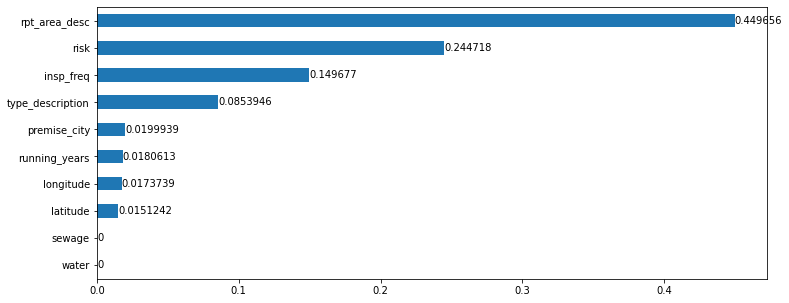

In [15]:
# Another way to do feature selection is using tree's feature importance.
# this way, we can see how each feature contributes to the classification task.
x_train, x_test, y_train, y_test = train_test_split(data.drop('est_group_desc', axis=1), data['est_group_desc'], test_size=.1, stratify=data['est_group_desc'])
x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values.astype(int), y_test.values.astype(int)

model = XGBClassifier(n_estimators=100, min_child_weight=1, max_depth=None, learning_rate=0.1)
model.fit(x_train, y_train)
model.feature_importances_
imp = pd.DataFrame(columns=data.drop('est_group_desc', axis=1).columns)
imp.loc[0, :] = model.feature_importances_
imp = imp.T.sort_values(0)
ax = imp.plot.barh(figsize=(12, 5), legend=False)
for c in ax.containers:
    ax.bar_label(c)

# As shown in below barplot, we can see that 'sewage' and 'water' are literally not helping at all,
# so we drop them for the further work.
df.drop(['water', 'sewage'], axis=1, inplace=True)

In [16]:
# Here we split the train & test dataset for our ML algos.
data, classes = data_encoding(df)
print(classes)
x_train, x_test, y_train, y_test = train_test_split(data.drop('est_group_desc', axis=1), data['est_group_desc'], test_size=.2, stratify=data['est_group_desc'])
x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values.astype(int), y_test.values.astype(int)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

est_group_desc
Fast Food Restaurant                482
Full-Service Restaurant             300
Elementary School                    91
Nursing Home                         37
Meat and Poultry Department          31
Deli Department                      30
Produce Department and Salad Bar     20
Hospital                              8
Seafood Department                    8
Name: count, dtype: int64
['Deli Department' 'Elementary School' 'Fast Food Restaurant'
 'Full-Service Restaurant' 'Hospital' 'Meat and Poultry Department'
 'Nursing Home' 'Produce Department and Salad Bar' 'Seafood Department']
(805, 8) (805,) (202, 8) (202,)


In [17]:
data

premise_city  running_years insp_freq est_group_desc risk   
id                                                                
56060            2       0.857192         3              3    4  \
58123            2       0.544863         3              6    4   
70266            2       0.348288         1              2    2   
97837            2       0.262329         1              3    2   
58349            2       0.565753         2              5    3   
...            ...            ...       ...            ...  ...   
80309            2       0.322603         2              2    3   
56881            2       0.517808         1              2    2   
56774            2       0.555822         1              2    2   
57189            2       0.388699         1              2    2   
57300            2       1.000000         3              2    4   

      type_description rpt_area_desc  latitude  longitude  
id                                                         
56060                0             0  0.167134   0.383724  
58123                3             0  0.518573   0.535254  
70266                0             0  0.160271   0.379261  
97837                0             0  0.439275   0.498405  
58349                6             0  0.247443   0.464563  
...                ...           ...       ...        ...  
80309                0             0  0.059820   0.621076  
56881                0             0  0.236152   0.349921  
56774                0             0  0.379327   0.506604  
57189                0             0  0.409145   0.462729  
57300                4             0  0.424441   0.440027  

[1007 rows x 9 columns]

In [18]:
# store all the classifers and fit the data to every model, then we can decide which model to use for filling up the missing values.
# Hyper-parameters of SVC, Decision Tree, Random Forest and Xgboost are estimated by GA based search techniques.

def get_best_params(classifers, cls_name):
    with open('./default_params/model_params.json', 'r') as p:
        param_grid = json.load(p)
    # param_search = GridSearchCV(estimator=classifers[cls_name], param_distributions=param_grid[cls_name], cv=5, scoring='accuracy')
    # param_search = RandomizedSearchCV(estimator=classifers[cls_name], param_distributions=param_grid[cls_name], n_iter=100, cv=5, scoring='accuracy')
    param_search = GeneticSearchCV(estimator=classifers[cls_name], param_grid=param_grid[cls_name], cv=5, scoring=['accuracy'])
    param_search.fit(x_train, y_train)
    return param_search.best_params_

classifers = {
    'Kneighbors': KNeighborsClassifier(),
    'SVC': SVC(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'Xgboost': XGBClassifier(),
    'GaussianNaiveBayes': GaussianNB()
}

best_acc = 0
for cls_name in classifers.keys():
    if cls_name in ['SVC', 'DecisionTree', 'RandomForest', 'Xgboost']:
        params = get_best_params(classifers, cls_name)
        classifers[cls_name] = classifers[cls_name].set_params(**params)
    classifers[cls_name].fit(x_train, y_train)

    if classifers[cls_name].score(x_test, y_test) > best_acc:
        best_acc = classifers[cls_name].score(x_test, y_test)
        best_model_name = cls_name

    print(f'{cls_name} Train: ', round(classifers[cls_name].score(x_train, y_train), 4))
    print(f'{cls_name} Test : ', round(classifers[cls_name].score(x_test, y_test), 4))

Kneighbors Train:  0.8621
Kneighbors Test :  0.802
SVC Train:  0.8484
SVC Test :  0.8465
DecisionTree Train:  0.8571
DecisionTree Test :  0.802
RandomForest Train:  0.9627
RandomForest Test :  0.8119
Xgboost Train:  0.9615
Xgboost Test :  0.8267
GaussianNaiveBayes Train:  0.3826
GaussianNaiveBayes Test :  0.3861


In [19]:
# We then use the classifer model with the highest accuracy among all other methods to fill up the missing values.
targets = df[df['est_group_desc'].isna()].drop('est_group_desc', axis=1)
inputs = data_encoding(targets)
outputs = classifers[best_model_name].predict(inputs.values)
targets.insert(5, 'est_group_desc', list(map(lambda x: classes[x], outputs)))
cleaned_data = pd.concat([df.dropna(axis=0), targets], axis=0)
cleaned_data

premise_city  running_years insp_freq               est_group_desc risk   
id                                                                              
56060       DURHAM          25.76         4      Full-Service Restaurant    4  \
58123       DURHAM          16.64         4                 Nursing Home    4   
70266       DURHAM          10.90         2         Fast Food Restaurant    2   
97837       DURHAM           8.39         2      Full-Service Restaurant    2   
58349       DURHAM          17.25         3  Meat and Poultry Department    3   
...            ...            ...       ...                          ...  ...   
59027       DURHAM          18.82         1         Fast Food Restaurant    0   
59033  MORRISVILLE          18.10         1         Fast Food Restaurant    0   
59005       DURHAM          18.80         1         Fast Food Restaurant    0   
59104       DURHAM          25.13         1         Fast Food Restaurant    0   
59106          RTP          25.88         1         Fast Food Restaurant    0   

                      type_description   rpt_area_desc   latitude  longitude  
id                                                                            
56060                   1 - Restaurant    Food Service  35.920727 -78.957330  
58123  16 - Institutional Food Service    Food Service  36.046780 -78.889548  
70266                   1 - Restaurant    Food Service  35.918265 -78.959326  
97837                   1 - Restaurant    Food Service  36.018338 -78.906031  
58349                 30 - Meat Market    Food Service  35.949532 -78.921169  
...                                ...             ...        ...        ...  
59027      50 - Seasonal Swimming Pool  Swimming Pools  35.940077 -78.890103  
59033      50 - Seasonal Swimming Pool  Swimming Pools  35.923603 -78.810959  
59005      50 - Seasonal Swimming Pool  Swimming Pools  35.907862 -78.920936  
59104                52 - Seasonal Spa  Swimming Pools  35.904176 -78.897425  
59106                52 - Seasonal Spa  Swimming Pools  35.877948 -78.838401  

[2431 rows x 9 columns]

# Visualization
Let's finally see how the data looked alike

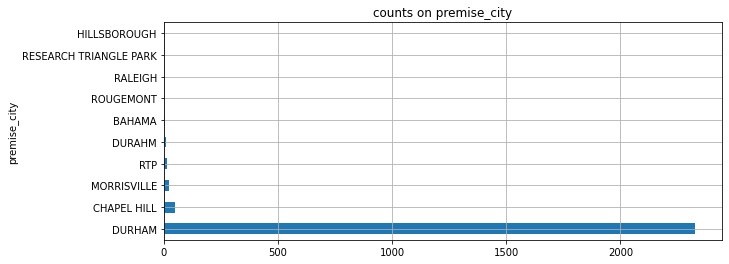

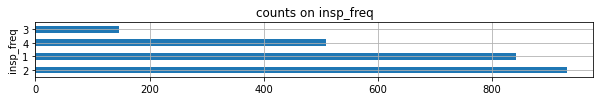

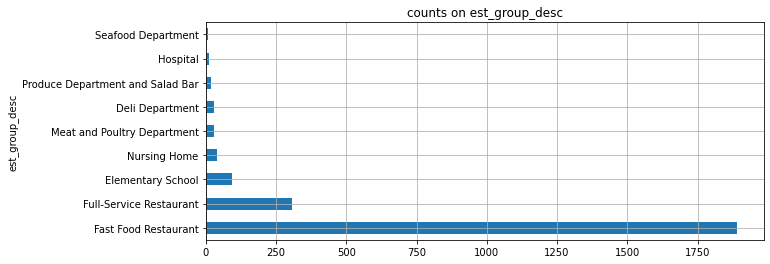

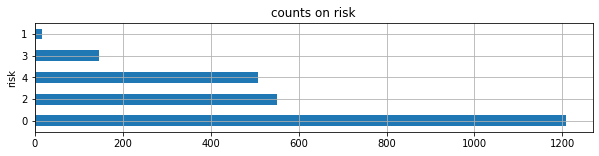

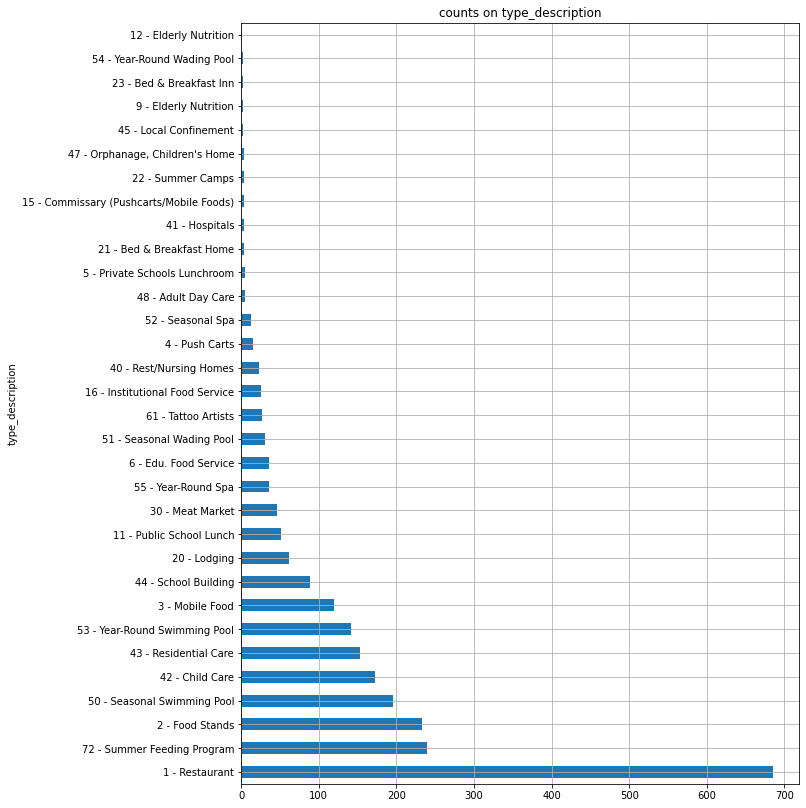

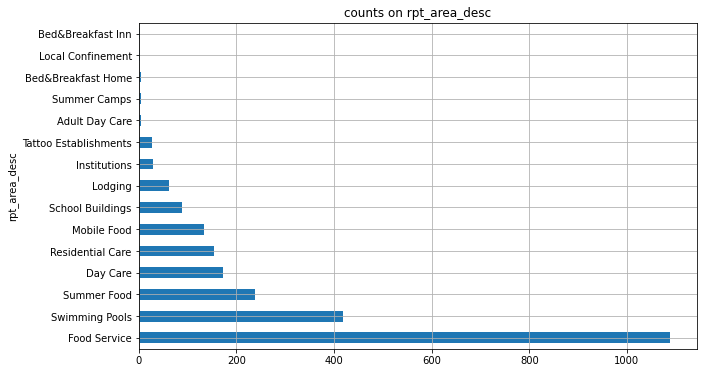

In [20]:
# View all the count on categorical data in plots.
for col in cleaned_data.select_dtypes(include='object').columns:
    cleaned_data[col].value_counts().plot(kind='barh', 
                                          grid=True, 
                                          figsize=(10, int(cleaned_data[col].value_counts().count()*0.45)), 
                                          title=f'counts on {col}')
    plt.show()

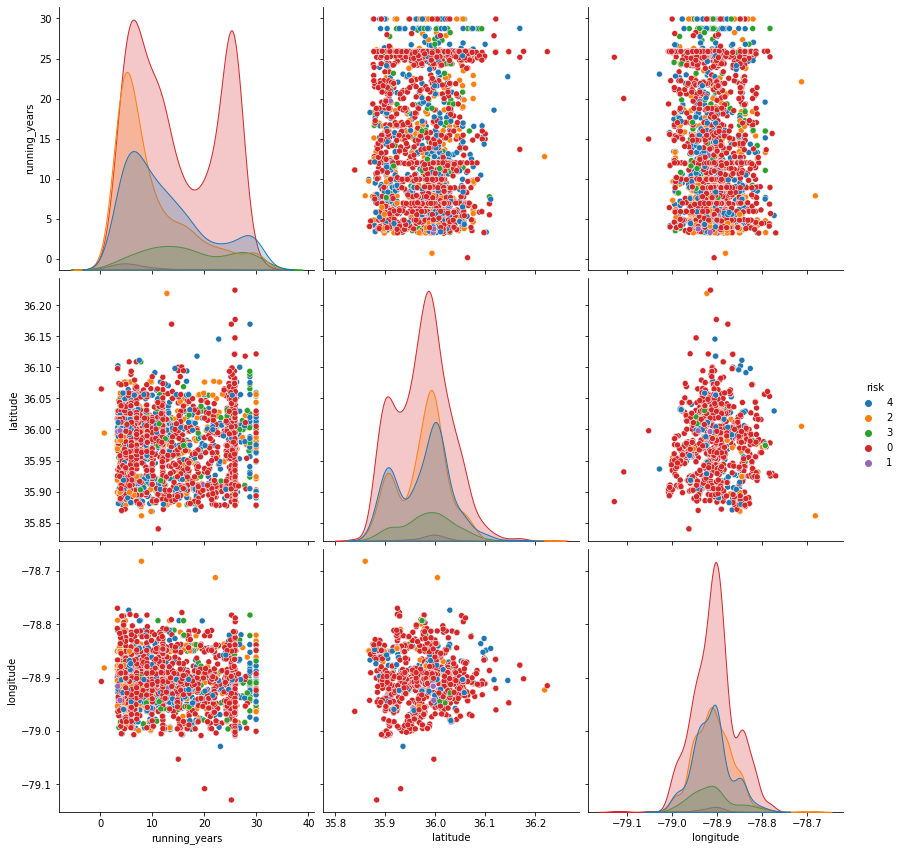

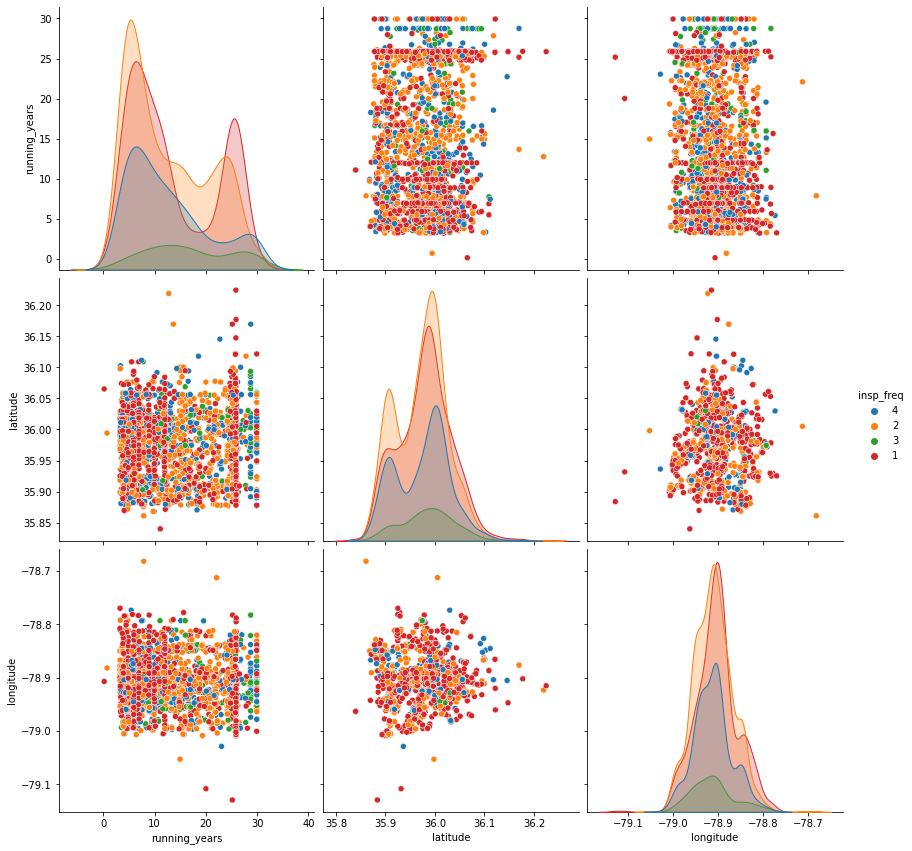

In [21]:
for col in ['risk', 'insp_freq']:
    sns.pairplot(cleaned_data, hue=col, height=4)

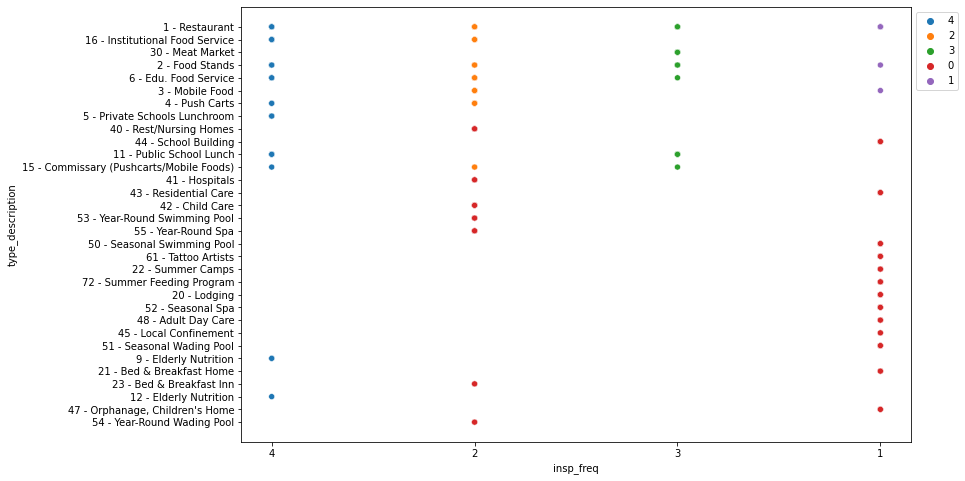

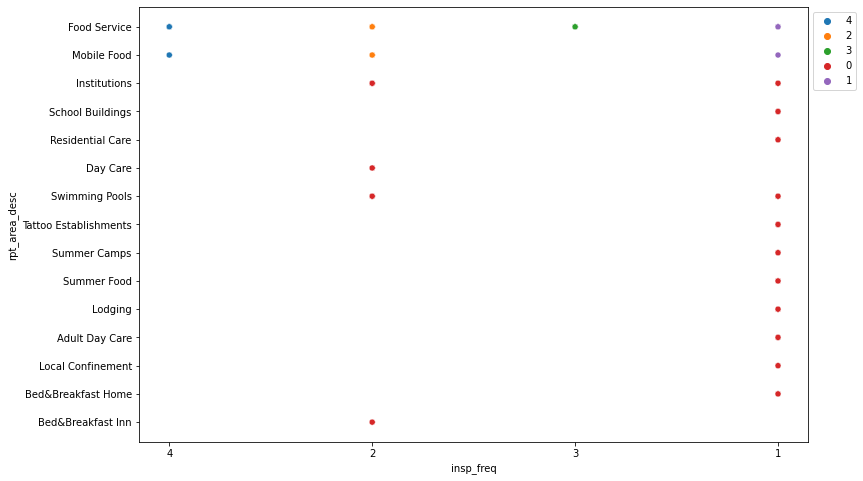

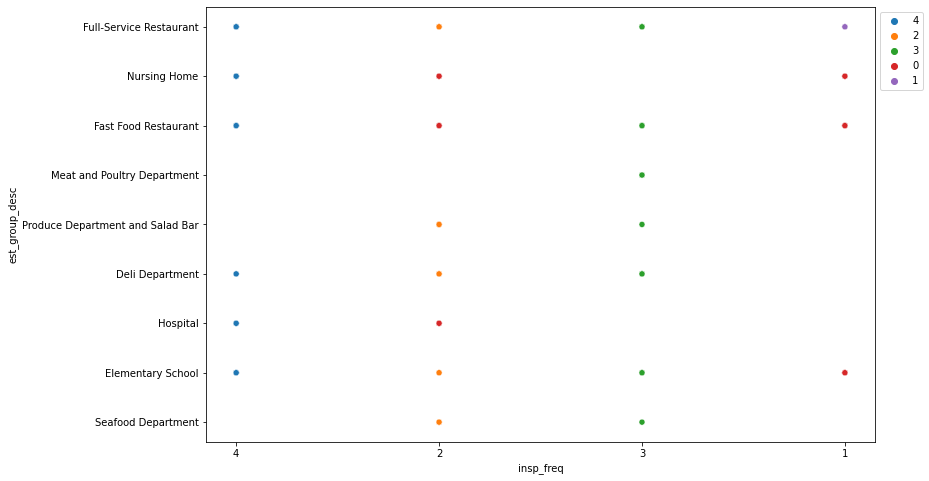

In [22]:
for col in ['type_description', 'rpt_area_desc', 'est_group_desc']:
    ax = plt.subplots(figsize=(12, 8))[1]
    sns.scatterplot(y=col, x='insp_freq', hue='risk', data=cleaned_data, ax=ax)
    plt.legend(bbox_to_anchor=(1, 1), loc=2)

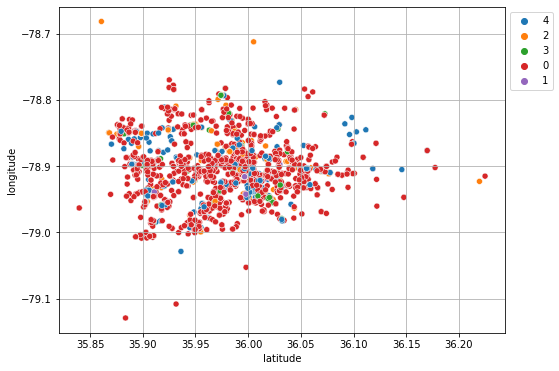

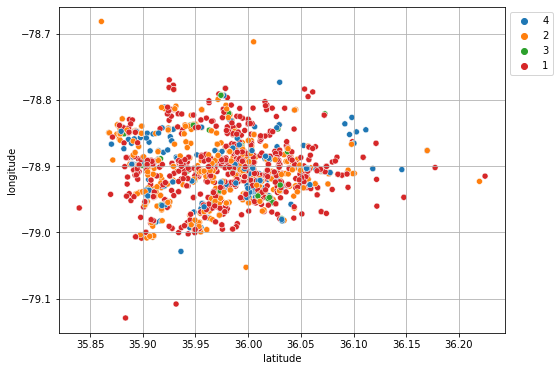

In [23]:
for col in ['risk', 'insp_freq']:
    ax = plt.subplots(figsize=(8, 6))[1]
    sns.scatterplot(y='longitude', x='latitude', hue=col, data=cleaned_data, ax=ax)
    plt.grid()
    plt.legend(bbox_to_anchor=(1, 1), loc=2)

In [24]:
# Optional
# In this step, we plot all coordination in map.
loc_center = [cleaned_data['latitude'].mean(), cleaned_data['longitude'].mean()]
map1 = folium.Map(location = loc_center, tiles='Openstreetmap', zoom_start = 10, control_scale=True)
for index, info in cleaned_data.iterrows():
    folium.Marker([info['latitude'], info['longitude']], 
                        radius=2, 
                        weight=5,
                        popup=info[-2:],
                        max_width=300,min_width=300).add_to(map1)
folium.LayerControl().add_to(map1)
map1.save('data_map.html')

In [25]:
map1